In [5]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from plotnine import *
sb.set() # set the default Seaborn style for graphics

In [3]:
#!pip install catboost
import catboost

# Dataset

In [6]:
# read data
flight_train_data=pd.read_csv('train.csv')
flight_test_data=pd.read_csv('test.csv')

In [7]:
print("Dimensions: ")
print('Train: ',flight_train_data.shape )
print('Test: ',flight_test_data.shape )

Dimensions: 
Train:  (100000, 9)
Test:  (100000, 8)


In [8]:
# combine train n test
data=pd.concat([flight_train_data,flight_test_data],axis=0,sort=False).reset_index()
# drop index columns
data=data.drop(['index'],axis=1)

In [9]:
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


- Observation:
    - train and tests are split 50-50 
    - train set has one additional response column as expected

# Response: dep_delayed_15min

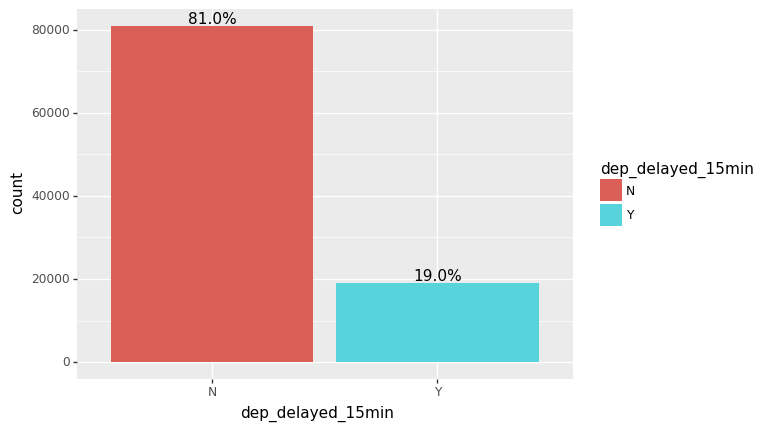

<ggplot: (-9223371892164961452)>

In [10]:
# count plot of response
ggplot(flight_train_data,aes(x='dep_delayed_15min',fill='dep_delayed_15min'))+geom_bar()+geom_text(
    aes(label='stat(prop)*100', group=1),
     stat='count',
     nudge_y=0.125,
     va='bottom',
     format_string='{:.1f}%'
 )

- Observation:
    - there is a class imbalance, only 19% of flights are delayed 15 minutes
- Action:
    - Stratified Kfold or SMOTE could be used later on to mitigate

# Data exploration

###  check NAs

In [11]:
data.isna().sum()

Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                   0
UniqueCarrier             0
Origin                    0
Dest                      0
Distance                  0
dep_delayed_15min    100000
dtype: int64

### check duplicates

In [12]:
data[data.duplicated()]

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min


- Observation:
    - there are no NAs(100000 NAs refer to test set) 
    - and no duplicates

### some cleaning

In [13]:
# extract only the numerics from these variable
for var in ['Month','DayofMonth','DayOfWeek']:
    data[var]=data[var].apply(lambda x: x.split('-')[1])

- Action:
    - 'Month','DayofMonth','DayOfWeek' have a pattern of: c-(number), so we use that to extract the numerics 

### visualising time-based variables

In [14]:
data.dtypes

Month                object
DayofMonth           object
DayOfWeek            object
DepTime               int64
UniqueCarrier        object
Origin               object
Dest                 object
Distance              int64
dep_delayed_15min    object
dtype: object

In [15]:
# time-based variables to int64
for i,var in enumerate(['Month','DayofMonth','DayOfWeek']):
    data[var]=data[var].astype('int64')

[Text(0, 0.5, 'Number of Flights')]

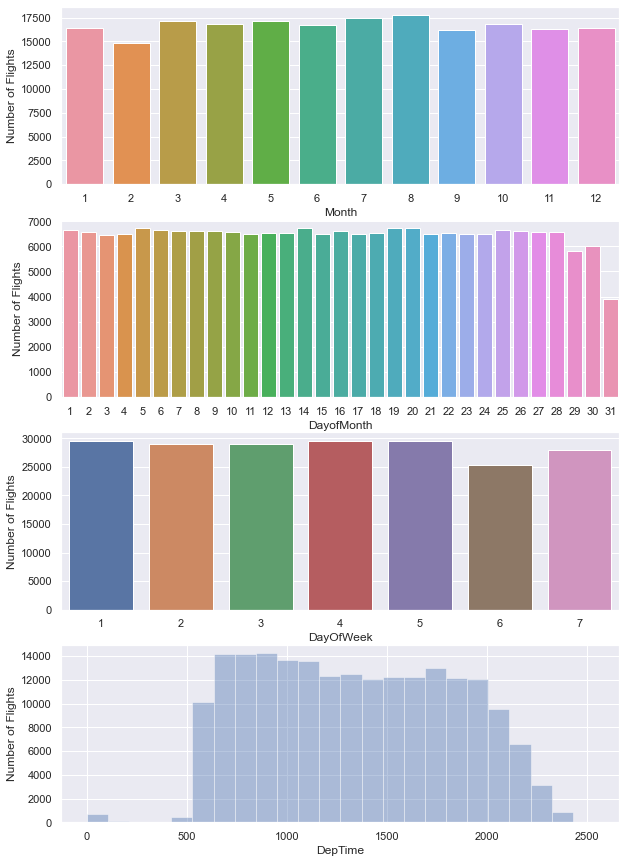

In [16]:
# visualising number of flights against time-based variables
f, axes = plt.subplots(4,1 , figsize=(10, 15))
for i,var in enumerate(['Month','DayofMonth','DayOfWeek']):
    sb.countplot(data=data,x=var,ax=axes[i]).set(ylabel='Number of Flights')
sb.distplot(data['DepTime'],bins=24,kde=False,ax=axes[3]).set(ylabel='Number of Flights')

- Observation:
    - February seems to have the least flights while August the most
    - Number of flights at the end of the month also seems to be the least
    - Weekends have fewer flights than weekdays
    - most flights occur 0600-2000, fewer flights are observed at other times

In [17]:
# encoding response variable/delay variable 
delay_encoding_0={'Y':1,'N':0}
data['dep_delayed_15min_encoded']=data['dep_delayed_15min'].map(delay_encoding_0)

In [18]:
# binned departure time
bins=[]
for i in range(24):
    tuple_bin=(i*100,i*100+59)
    bins.append(tuple_bin)
interval_bins = pd.IntervalIndex.from_tuples(bins)
data['DepTime_binned']=pd.cut(data['DepTime'],interval_bins)

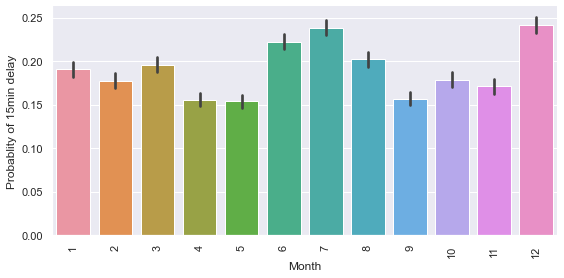

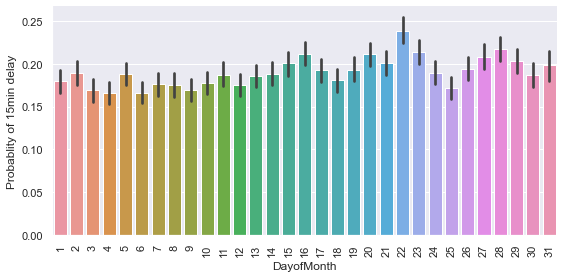

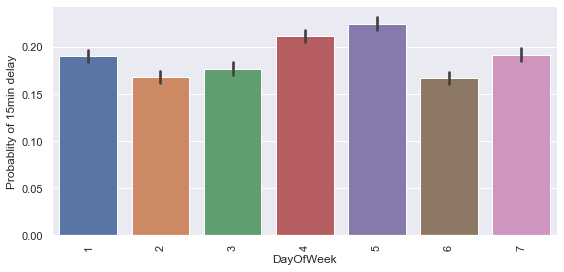

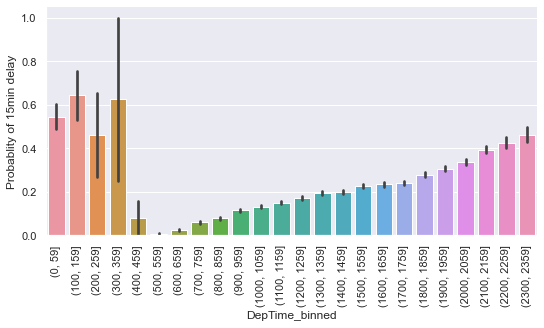

In [19]:
# visualise likelihood of 15 min delay agaianst the time-based variables
for i,var in enumerate(['Month','DayofMonth','DayOfWeek','DepTime_binned']):
    sb.catplot(x=var,y='dep_delayed_15min_encoded',data=data,kind='bar',height=4, aspect=2).set(ylabel='Probablity of 15min delay').set_xticklabels(rotation=90)

- Observation:
    - most predictive indicators:
        - mid-year
        - end of year
        - fridays
        - time of day
    - more interestingly, the likelihood of a flight delay increments starting from 0500 to 2359
    - looking at departure times, it seems like even though the number of flights from 0000 to 0359 is very low,
        likelihood of a late flight is the highest. same goes for flights 2100 onwards


In [20]:
# create a date column
data['date']=pd.to_datetime('2018/'+data.Month.astype(str)+'/'+data.DayofMonth.astype(str))

In [21]:
# create likelihood of a late flight on any day of the year
daily_late_likelihood_encoding=data.groupby(['date'])['dep_delayed_15min_encoded'].agg(['mean','count'])['mean']
data['daily_late_likelihood']=data['date'].map(daily_late_likelihood_encoding)
# create number of flights on any day of the year
daily_flight_count_encoding=data.groupby(['date'])['dep_delayed_15min_encoded'].agg(['mean','count'])['count']
data['daily_flight_count']=data['date'].map(daily_flight_count_encoding)

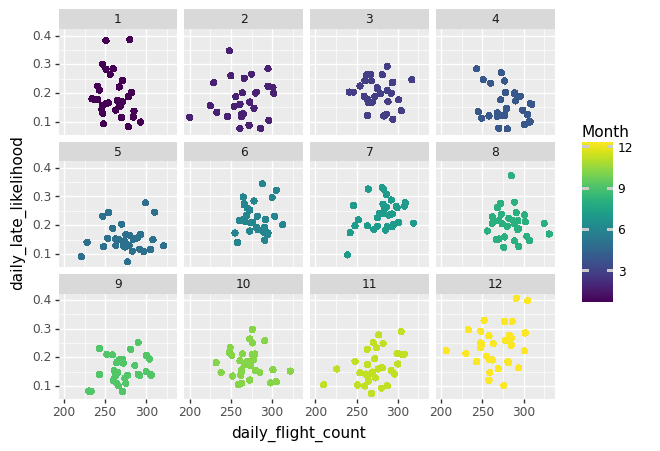

<ggplot: (-9223371892163376984)>

In [22]:
ggplot(data,aes(x='daily_flight_count',y='daily_late_likelihood'))+geom_point(aes(color='Month'))+facet_wrap('Month')

- Observation:
    - looks like there is a **poor correlation between number of fights in any given day and the likelihood of a late flight**

In [23]:
# create likelihood of a late flight in a month 
monthly_late_likelihood=data.groupby(['Month'])['dep_delayed_15min_encoded'].agg(['mean','count'])['mean']
# create number of flights in a month
monthly_flight_count=data.groupby(['Month'])['dep_delayed_15min_encoded'].agg(['mean','count'])['count']

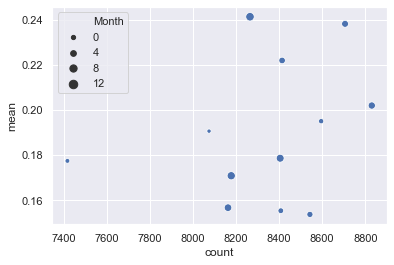

In [24]:
# scatterplot showing number of flights in a month against likelihood of late flight
temp_monthly_df=pd.concat([monthly_flight_count,monthly_late_likelihood],axis=1).reset_index()
sb.scatterplot(data=temp_monthly_df,x='count',y='mean',size=temp_monthly_df.Month)

- Observation:
    - there are too little data points to discern anything. however, number of flights may have very little correlation w delay

### visualising holidays

In [21]:
# %pip install holidays
import holidays
for date,holiday in holidays.UnitedStates(years=2018).items():
    print(date,holiday)

2018-01-01 New Year's Day
2018-01-15 Martin Luther King Jr. Day
2018-02-19 Washington's Birthday
2018-05-28 Memorial Day
2018-07-04 Independence Day
2018-09-03 Labor Day
2018-10-08 Columbus Day
2018-11-11 Veterans Day
2018-11-12 Veterans Day (Observed)
2018-11-22 Thanksgiving
2018-12-25 Christmas Day


In [22]:
# create new feature: holiday or not
holiday_dates=pd.to_datetime(list(holidays.UnitedStates(years=2018).keys()))
data=data.assign(holiday=data['date'].apply(lambda x: 1 if x in holiday_dates else 0))

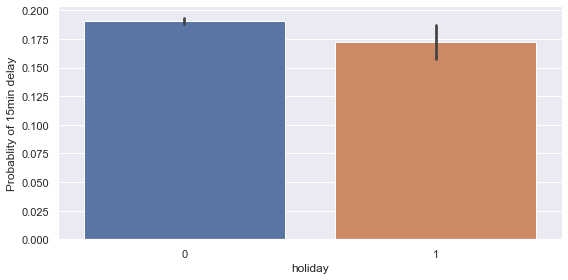

In [23]:
sb.catplot(x='holiday',y='dep_delayed_15min_encoded',data=data,kind='bar',height=4, aspect=2).set(ylabel='Probablity of 15min delay')

- Observation:
    - on the day of the holiday, flights are slightly less likely to be late

In [24]:
# get list of dates before and after holiday
import datetime
before_holiday=[]
after_holiday=[]
for date in holiday_dates:
    for i in range(1,5):
        previous_date=date-datetime.timedelta(days=i)
        coming_date=date+datetime.timedelta(days=i)
        before_holiday.append(previous_date)
        after_holiday.append(coming_date)

before_holiday=pd.to_datetime(before_holiday)
after_holiday=pd.to_datetime(after_holiday)

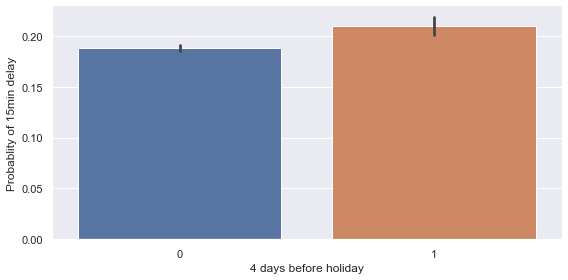

In [25]:
data=data.assign(before_holiday=data['date'].apply(lambda x: 1 if x in before_holiday else 0))
sb.catplot(x='before_holiday',y='dep_delayed_15min_encoded',data=data,kind='bar',height=4, aspect=2).set(ylabel='Probablity of 15min delay',xlabel='4 days before holiday')

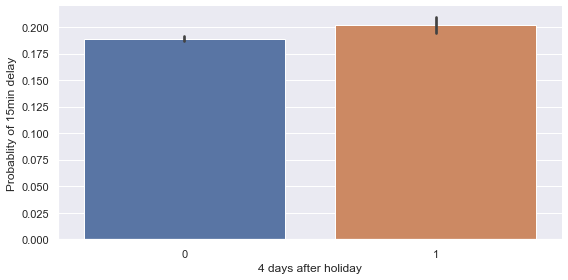

In [26]:
data=data.assign(after_holiday=data['date'].apply(lambda x: 1 if x in after_holiday else 0))
sb.catplot(x='after_holiday',y='dep_delayed_15min_encoded',data=data,kind='bar',height=4, aspect=2).set(ylabel='Probablity of 15min delay',xlabel='4 days after holiday')

In [27]:
# new feature: number of days from any holiday
all_dates_list=pd.to_datetime(data['date'].sort_values().unique())
days_from_holiday=[]
for date in all_dates_list:
    smallest_difference=999
    for holiday in holiday_dates:
        difference=(date-holiday).days
        if(abs(difference)<smallest_difference):
            smallest_difference=difference
    days_from_holiday.append(smallest_difference)
days_from_holiday_mapping=dict(zip(all_dates_list,days_from_holiday))
data=data.assign(days_from_holiday=data['date'].map(days_from_holiday_mapping))


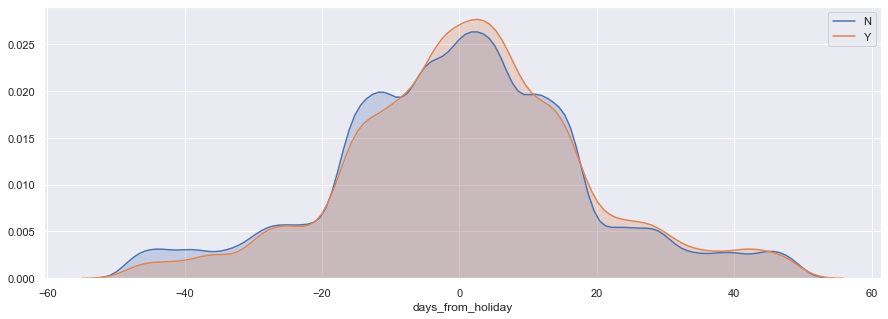

In [28]:
f, axes = plt.subplots(1,1 , figsize=(15,5))
for level in data['dep_delayed_15min'].unique():
    sb.kdeplot(data[data['dep_delayed_15min']==level]['days_from_holiday'],shade=True,label=level).set(xlabel='days_from_holiday')

- Observations:
    - flights closer to holidays are more likely to be delayed
    - flights a week before a holiday are less likely to be delayed

### visualising effect of number of delays from the previous 10 flights

In [29]:
# sort flights by date and time
testor=data.copy()
testor.dropna(subset=['dep_delayed_15min_encoded'],axis=0,inplace=True)
subset=testor.sort_values(by=['date','DepTime'])
delayed_subset=subset['dep_delayed_15min_encoded']

In [30]:
# encode flights by their sum of flights delays out of the previous 10 flights
number_of_delays_previous_10=[]
for day in subset['date'].unique():
    daily_flight_delays=subset[subset['date']==day]['dep_delayed_15min_encoded']
    for i in range(10):
        number_of_delays_previous_10.append(None)
    for ordered_flight in range(10,len(daily_flight_delays)):
        temp=daily_flight_delays[ordered_flight-10:ordered_flight].sum()
        number_of_delays_previous_10.append(temp)

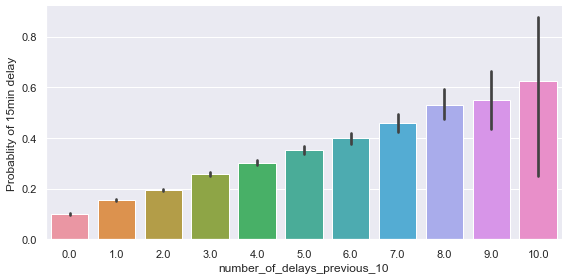

In [31]:
subset['number_of_delays_previous_10']=number_of_delays_previous_10
sb.catplot(x='number_of_delays_previous_10',y='dep_delayed_15min_encoded',data=subset,kind='bar',height=4, aspect=2).set(ylabel='Probablity of 15min delay')

- Observation:
    - flights delays can snowball, which explains why likelihood of delays increase throughout the day

### visualising UniqueCarrier

In [32]:
print("Unique carriers: ",data.UniqueCarrier.unique())
print("Number of unique carriers: ",len(data.UniqueCarrier.unique()))

Unique carriers:  ['AA' 'US' 'XE' 'OO' 'WN' 'NW' 'DL' 'OH' 'AS' 'UA' 'MQ' 'CO' 'EV' 'DH'
 'YV' 'F9' 'AQ' 'TZ' 'HP' 'B6' 'FL' 'HA' '9E']
Number of unique carriers:  23


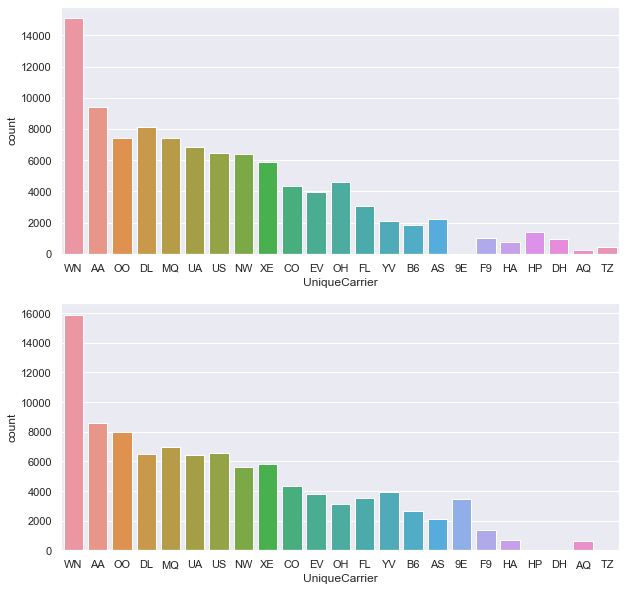

In [33]:
# value counts of Carriers (training set followed by test set)
f, axes = plt.subplots(2,1 , figsize=(10, 10))
for i,sets in enumerate([flight_train_data,flight_test_data]):
    sb.countplot(data=sets,x='UniqueCarrier',ax=axes[i],order=list(data.UniqueCarrier.value_counts().index))

- Obseravtion:
    - **Carrier 9E is present in test set but completely missing in the training set**
    - **certain carriers present in the training set is also absent from the test set**

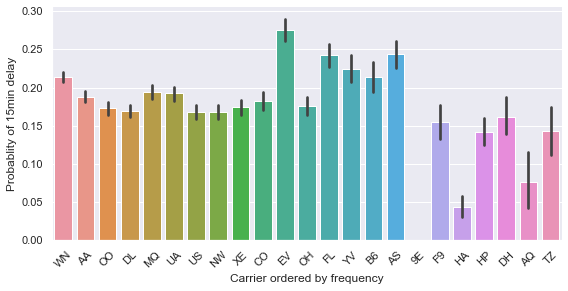

In [34]:
sb.catplot(x='UniqueCarrier',y='dep_delayed_15min_encoded',data=data,kind='bar',height=4, aspect=2,order=list(data.UniqueCarrier.value_counts().index)).set(ylabel='Probablity of 15min delay').set_xticklabels(rotation=45).set(xlabel='Carrier ordered by frequency')

- Observation:
    - the above plot also orders carriers by frequency.
    - even though carriers like EV and AS are not as frequent, their likelihood of being late is much higher
    - this concludes that the **competency of carriers is also a factor** in determining whether a flight is late
        - e.g. EV carrier may not be as good (in terms of punctuality) compared to OO carrier

In [35]:
# labels a categorical variable by their rank based on frequency
def labelcount_encode(X, categorical_features, ascending=False):
    print('LabelCount encoding: {}'.format(categorical_features))
    X_ = pd.DataFrame()
    for cat_feature in categorical_features:
        cat_feature_value_counts = X[cat_feature].value_counts()
        value_counts_list = cat_feature_value_counts.index.tolist()
        if ascending:
            # for ascending ordering
            value_counts_range = list(
                reversed(range(len(cat_feature_value_counts))))
        else:
            # for descending ordering
            value_counts_range = list(range(len(cat_feature_value_counts)))
        labelcount_dict = dict(zip(value_counts_list, value_counts_range))
        X_[cat_feature] = X[cat_feature].map(
            labelcount_dict)
    X_ = X_.add_suffix('_labelcount_encoded')
    if ascending:
        X_ = X_.add_suffix('_ascending')
    else:
        X_ = X_.add_suffix('_descending')
    X_ = X_.astype(np.uint32)
    return X_

In [36]:
# encode UniqueCarrier by frequency rank
data=pd.concat([data,labelcount_encode(data,['UniqueCarrier'], ascending=True)],axis=1)

LabelCount encoding: ['UniqueCarrier']


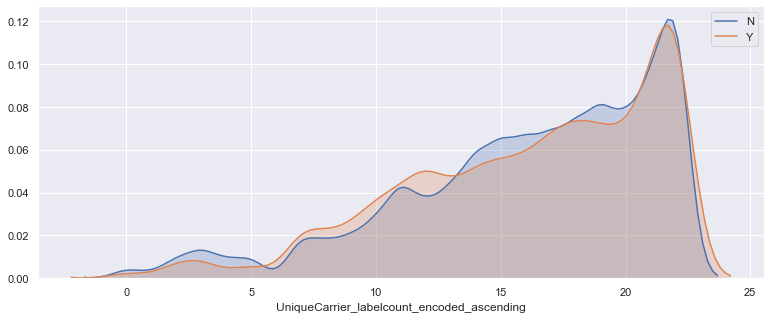

In [37]:
f, axes = plt.subplots(1,1 , figsize=(13,5))
for level in data['dep_delayed_15min'].unique():
    sb.kdeplot(data[data['dep_delayed_15min']==level]['UniqueCarrier_labelcount_encoded_ascending'],shade=True,label=level).set(xlabel='UniqueCarrier_labelcount_encoded_ascending')

- Observation:
    - most frequnt carriers are more likely to be late
    - moderately frequent carriers(rank 16-20) are less likely to be late
    - less frequent carriers(rank 6-16) are more likely to be late

### Origin and Destinations

In [38]:
print("Number of levels: ")
for var in ['Origin','Dest']:
    print('{:<10}:{}'.format(var,len(data.Origin.unique())))

Number of levels: 
Origin    :307
Dest      :307


In [39]:
print("Value counts: ")
for var in ['Origin','Dest']:
    print(data[var].value_counts())

Value counts: 
ATL    11387
ORD     9823
DFW     8163
LAX     6434
DEN     6222
       ...  
CMX        2
ALO        2
EAU        1
VCT        1
VIS        1
Name: Origin, Length: 307, dtype: int64
ATL    11382
ORD     9877
DFW     8290
LAX     6445
DEN     6115
       ...  
EAU        1
ADK        1
MTH        1
BJI        1
VCT        1
Name: Dest, Length: 307, dtype: int64


- Observation:
    - Conveniently, there is the same number of Origin and Dest airports

In [40]:
# encode by frequency rank
data=pd.concat([data,labelcount_encode(data,['Origin','Dest'], ascending=True)],axis=1)

LabelCount encoding: ['Origin', 'Dest']


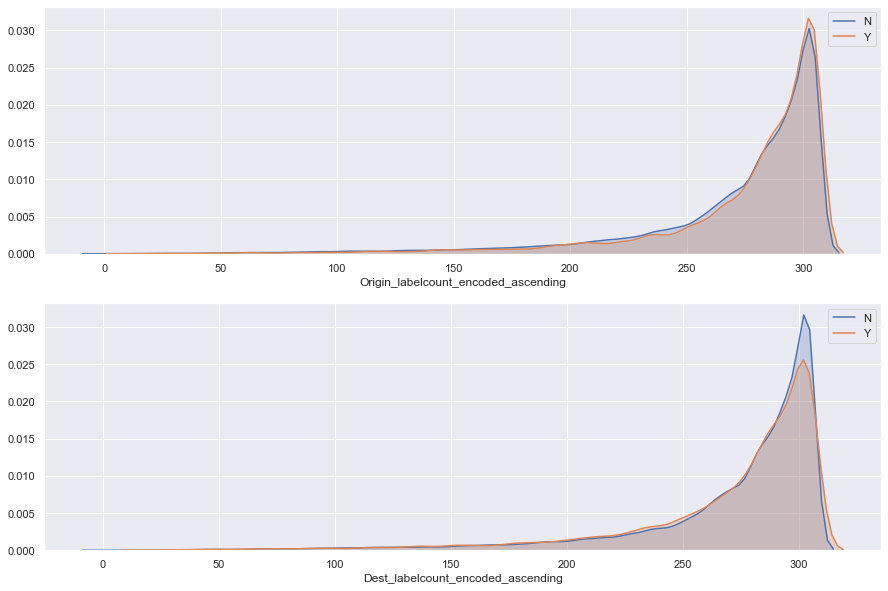

In [42]:
f, axes = plt.subplots(2,1 , figsize=(15,10))
for level in data['dep_delayed_15min'].unique():
    sb.kdeplot(data[data['dep_delayed_15min']==level]['Origin_labelcount_encoded_ascending'],shade=True,label=level,ax=axes[0]).set(xlabel='Origin_labelcount_encoded_ascending')
for level in data['dep_delayed_15min'].unique():
    sb.kdeplot(data[data['dep_delayed_15min']==level]['Dest_labelcount_encoded_ascending'],shade=True,label=level,ax=axes[1]).set(xlabel='Dest_labelcount_encoded_ascending')

- Observation:
    - more frequent origin airports actually have a **higher likelihood of being late(larger orange area under curve)**
    - less frequent origin airports have a lower likelihood of being late(smaller orange area under curve)
    - the effects are very marginal however.
    - for dest airports around the rank of 300 in frequency have **less likelihood of being late**

In [43]:
# combining Origin n Dest
data['Origin-Dest']=data['Origin']+data['Dest']
# frequency encode
data=pd.concat([data,labelcount_encode(data,['Origin-Dest'], ascending=True)],axis=1)


LabelCount encoding: ['Origin-Dest']


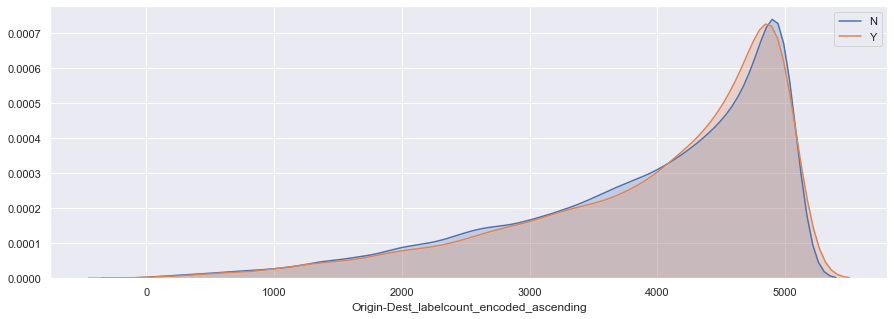

In [45]:
f, axes = plt.subplots(1,1 , figsize=(15,5))
for level in data['dep_delayed_15min'].unique():
    sb.kdeplot(data[data['dep_delayed_15min']==level]['Origin-Dest_labelcount_encoded_ascending'],shade=True,label=level).set(xlabel='Origin-Dest_labelcount_encoded_ascending')

- Observation:
    - certain origin-dest pairs actually have a lower than average likelihood of being late
    - on the other hand, certain origin-dest pairs actually have a **higher than average likelihood of being late**, even though they are quite frequent occurences

### distance

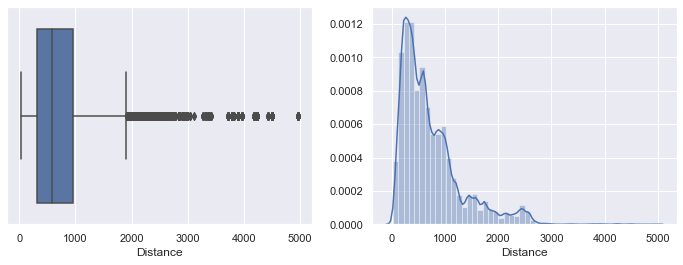

In [46]:
# uni-variate plots
f, axes = plt.subplots(1,2 , figsize=(12,4))
sb.boxplot(data.Distance,ax=axes[0])
sb.distplot(data.Distance,ax=axes[1])

- Observation:
    - most flights are around 250 to 1000 miles

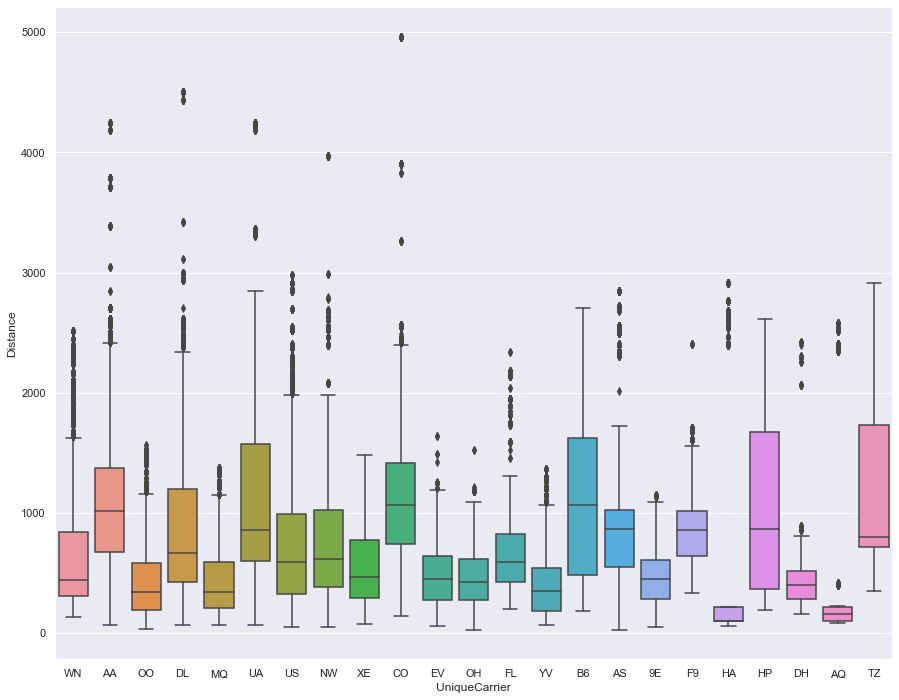

In [47]:
# distance against unique carriers
f, axes = plt.subplots(1,1 , figsize=(15,12))
sb.boxplot(data=data,x='UniqueCarrier',y='Distance',order=list(data.UniqueCarrier.value_counts().index))

- Observation:
    - certain carriers tend to service flights that are shorter in distance like HA and AQ, which may be a reason why their lieklihood of delay is low
    - however, there are cases when this notion does not hold.
        - e.g. WN has a lower distance IQR than UA, but UA has a lower likelihood of a late flight

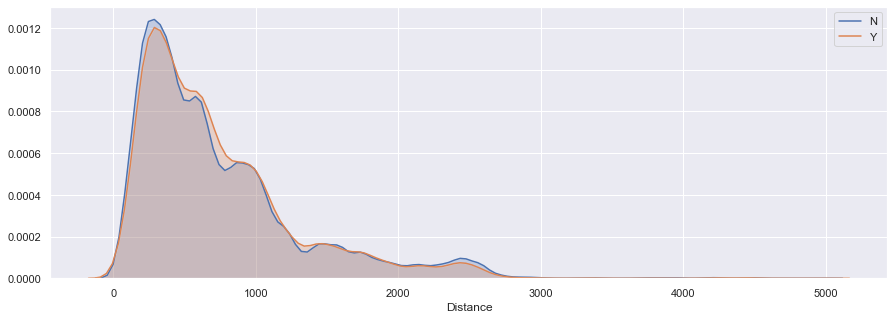

In [49]:
# KDE of flight distance segmented by the response
f, axes = plt.subplots(1,1 , figsize=(15,5))
for level in data['dep_delayed_15min'].unique():
    sb.kdeplot(data[data['dep_delayed_15min']==level]['Distance'],shade=True,label=level).set(xlabel='Distance')

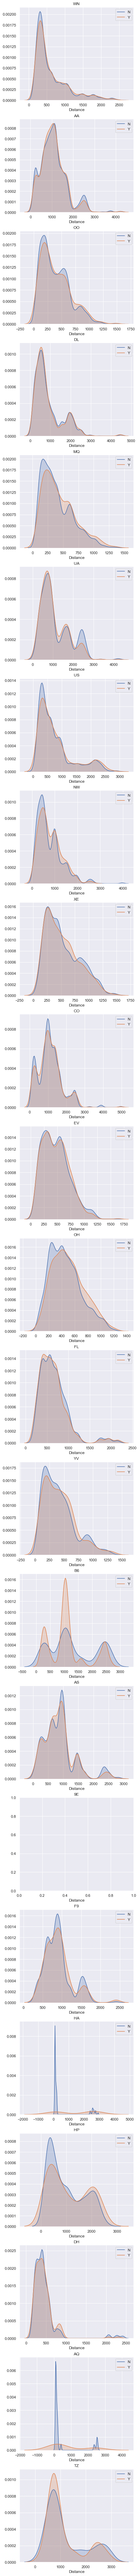

In [50]:
# these plots are also ordered by frequnecy of the carrier in descending order
multiplier=len(data.UniqueCarrier.unique())
f, axes = plt.subplots(multiplier,1 , figsize=(6,6*multiplier))
for i,carrier in enumerate(list(data.UniqueCarrier.value_counts().index)):
    subset=data[data['UniqueCarrier']==carrier][['Distance','dep_delayed_15min']]
    for level in data['dep_delayed_15min'].unique():
        sb.kdeplot(subset[subset['dep_delayed_15min']==level]['Distance'],shade=True,label=level,ax=axes[i]).set(title=carrier,xlabel='Distance')

- Observation:
    - for carrier like MQ, NW and OH lower distance travels are more likely to be late(higher area under curve)
    - however, this notion does not hold for certain less frequent carriers like TZ and B6

### visualising extreme weather(US)

In [51]:
# dates extracted from: https://www.weather.gov/mob/events
extreme_weather=pd.to_datetime(['2018-12-27','2018-12-28','2018-11-30','2018-12-01','2018-11-12','2018-11-01','2018-10-10',
                '2018-09-04','2018-09-05','2018-07-22','2018-06-28','2018-04-14','2018-02-10','2018-01-16','2018-01-17',
                 '2018-05-28'])

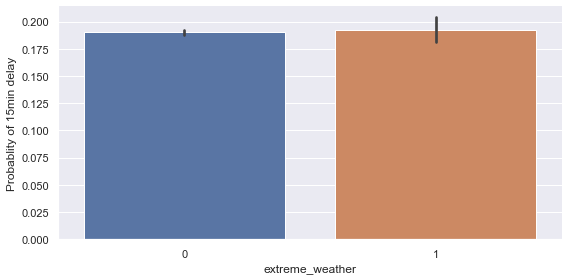

In [52]:
data=data.assign(extreme_weather=data['date'].apply(lambda x: 1 if x in extreme_weather else 0))
sb.catplot(x='extreme_weather',y='dep_delayed_15min_encoded',data=data,kind='bar',height=4, aspect=2).set(ylabel='Probablity of 15min delay')

- Observation:
    - extreme weather should cause delays logically, however, the effect is probably very local and minimal

# Data preparation

In [20]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
from plotnine import *
sb.set() # set the default Seaborn style for graphics

In [21]:
# read data
flight_train_data=pd.read_csv('train.csv')
flight_test_data=pd.read_csv('test.csv')
# combine train n test
data_preprocessing=pd.concat([flight_train_data,flight_test_data],axis=0,sort=False).reset_index()
# drop index columns
data_preprocessing=data_preprocessing.drop(['index'],axis=1)

### time-based columns

In [22]:
# extract only the numerics from these variable
for var in ['Month','DayofMonth','DayOfWeek']:
    data_preprocessing[var]=data_preprocessing[var].apply(lambda x: x.split('-')[1])

In [23]:
# bin departure time
bins=[]
for i in range(24):
    tuple_bin=(i*100,i*100+59)
    bins.append(tuple_bin)
interval_bins = pd.IntervalIndex.from_tuples(bins)
data_preprocessing['DepTime_binned']=pd.cut(data_preprocessing['DepTime'],interval_bins)
data_preprocessing['DepTime_binned']=data_preprocessing['DepTime_binned'].map(dict(zip(list(interval_bins),range(24))))

#convert time-base columns to int

for var in ['Month','DayofMonth','DayOfWeek']:
    data_preprocessing[var]=data_preprocessing[var].astype(int)

#function that converts variable to a cyclical feature

def encode_cyclical_feature(data, col):
    max_val=data[col].max()
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

#convert variables to cyclical

for var in ['Month','DayofMonth','DayOfWeek']:
    encode_cyclical_feature(data_preprocessing,var)


#scatter plot to check conversion

scatterplot_list=[('Month_sin', 'Month_cos'), ('DepTime_binned_sin', 'DepTime_binned_cos'),('DayofMonth_sin', 'DayofMonth_cos'), ('DayOfWeek_sin', 'DayOfWeek_cos')]
f, axes = plt.subplots(4,1 , figsize=(5,15))
for i,pair in enumerate(scatterplot_list)
    sb.scatterplot(data=data_preprocessing,x=pair[0],y=pair[1],ax=axes[i])

In [25]:
data_preprocessing.dtypes

Month                  object
DayofMonth             object
DayOfWeek              object
DepTime                 int64
UniqueCarrier          object
Origin                 object
Dest                   object
Distance                int64
dep_delayed_15min      object
DepTime_binned       category
dtype: object

- Action:
    

### new feature: days from holiday

In [ ]:
# get list of holidays
import holidays
holiday_dates=pd.to_datetime(list(holidays.UnitedStates(years=2018).keys()))

In [ ]:
# create a date column
data_preprocessing['date']=pd.to_datetime('2018/'+data_preprocessing.Month.astype(str)+'/'+data_preprocessing.DayofMonth.astype(str))

In [ ]:
# list all dates in order
all_dates_list=pd.to_datetime(data_preprocessing['date'].sort_values().unique())
# find the corresponding number of days from holiday
days_from_holiday=[]
for date in all_dates_list:
    smallest_difference=999
    for holiday in holiday_dates:
        difference=(date-holiday).days
        if(abs(difference)<smallest_difference):
            smallest_difference=difference
    days_from_holiday.append(smallest_difference)
# dictionary used for mapping
days_from_holiday_mapping=dict(zip(all_dates_list,days_from_holiday))
# .map() method to map every date to their corresponding number of days from holiday
data_preprocessing=data_preprocessing.assign(days_from_holiday=data_preprocessing['date'].map(days_from_holiday_mapping))

- Action:
    - created new feature, days_from_holiday, because dates closer to holidays are more likely to be delayed

### UniqueCarrier

In [ ]:
# labels a categorical variable by their rank based on frequency
def labelcount_encode(X, categorical_features, ascending=False):
    print('LabelCount encoding: {}'.format(categorical_features))
    X_ = pd.DataFrame()
    for cat_feature in categorical_features:
        cat_feature_value_counts = X[cat_feature].value_counts()
        value_counts_list = cat_feature_value_counts.index.tolist()
        if ascending:
            # for ascending ordering
            value_counts_range = list(
                reversed(range(len(cat_feature_value_counts))))
        else:
            # for descending ordering
            value_counts_range = list(range(len(cat_feature_value_counts)))
        labelcount_dict = dict(zip(value_counts_list, value_counts_range))
        X_[cat_feature] = X[cat_feature].map(
            labelcount_dict)
    X_ = X_.add_suffix('_labelcount_encoded')
    if ascending:
        X_ = X_.add_suffix('_ascending')
    else:
        X_ = X_.add_suffix('_descending')
    X_ = X_.astype(np.uint32)
    return X_

#encode UniqueCarrier by frequency rank

data_preprocessing=pd.concat([data_preprocessing,labelcount_encode(data_preprocessing,['UniqueCarrier'], ascending=True)],axis=1)

- Action:
    - this time, since i am use cat boost, i will keep this variable as categoric variable rather than count encoding because catboost takes care of categorical variables
  

### Origin_Dest

In [ ]:
#combining Origin n Dest

data_preprocessing['Origin-Dest']=data_preprocessing['Origin']+data_preprocessing['Dest']

#frequency encode
#data_preprocessing=pd.concat([data_preprocessing,labelcount_encode(data_preprocessing,['Origin-Dest'], ascending=True)],axis=1)

- Action:
    - created a new variable by combining origin and destination, but i will not frequency encode this time

### drop remaining variables

In [26]:
data_preprocessing.drop(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier','Origin', 'Dest','date','DepTime_binned','Origin-Dest'],axis=1,inplace=True)

- Action:
    - dropped because i won't use these variables in the models

### scale variables

In [27]:
# define function that applies normalization
def normalization(target_data,target_variable):
    target_series=target_data[target_variable]
    minimum=target_series.min()
    maximum=target_series.max()
    resultant_series=(target_series-minimum)/(maximum-minimum)
    return resultant_series

In [28]:
for var in ['Distance','days_from_holiday','Origin-Dest_labelcount_encoded_ascending','UniqueCarrier_labelcount_encoded_ascending']:
    data_preprocessing[var]=normalization(data_preprocessing,var)

- Action:
    - normalized variables so features are in the same scale. speed and performance may improve for certain models

### encode response

In [29]:
response_encoding_map={'Y':1,'N':0}
data_preprocessing['dep_delayed_15min']=data_preprocessing['dep_delayed_15min'].map(response_encoding_map)

### separate to train and test set

In [30]:
test_set=data_preprocessing[data_preprocessing['dep_delayed_15min'].isna()]
training_set=data_preprocessing[~data_preprocessing['dep_delayed_15min'].isna()]

In [31]:
# separate response from predictors
y=training_set['dep_delayed_15min']
X=training_set.drop(['dep_delayed_15min'],axis=1)
test_set=test_set.drop(['dep_delayed_15min'],axis=1)


In [32]:
# safe a copy of the columns sequence
column_sequence=test_set.columns

In [33]:
X.head()

,Distance,Month_sin,Month_cos,DayofMonth_sin,DayofMonth_cos,DayOfWeek_sin,DayOfWeek_cos,DepTime_binned_sin,DepTime_binned_cos,days_from_holiday,UniqueCarrier_labelcount_encoded_ascending,Origin-Dest_labelcount_encoded_ascending
0,0.142336,-0.866025,-5.000000e-01,-0.897805,-0.440394,-2.449294e-16,1.000000,-8.878852,4.600650,0.360825,0.954545,0.994056
1,0.163017,0.866025,-5.000000e-01,-0.790776,-0.612106,4.338837e-01,-0.900969,-8.169699,-5.766803,0.103093,0.727273,0.895582
2,0.078264,-1.000000,-1.836970e-16,0.394356,0.918958,-9.749279e-01,-0.222521,-6.310879,-7.757113,0.484536,0.636364,0.613037
3,0.170722,-0.500000,8.660254e-01,-0.937752,0.347305,-7.818315e-01,0.623490,3.984011,-9.172113,0.525773,0.909091,0.778086
4,0.079684,-0.866025,5.000000e-01,0.988468,0.151428,-7.818315e-01,0.623490,-9.790841,2.034560,0.484536,1.000000,0.742421


In [34]:
test_set.head()

,Distance,Month_sin,Month_cos,DayofMonth_sin,DayofMonth_cos,DayOfWeek_sin,DayOfWeek_cos,DepTime_binned_sin,DepTime_binned_cos,days_from_holiday,UniqueCarrier_labelcount_encoded_ascending,Origin-Dest_labelcount_encoded_ascending
100000,0.115166,-5.000000e-01,-8.660254e-01,-0.937752,0.347305,4.338837e-01,-0.900969,9.976688,-0.682424,0.711340,0.409091,0.373489
100001,0.244323,8.660254e-01,-5.000000e-01,-0.299363,-0.954139,9.749279e-01,-0.222521,9.422609,-3.348796,0.072165,1.000000,0.673469
100002,0.110908,-2.449294e-16,1.000000e+00,0.394356,0.918958,-2.449294e-16,1.000000,9.976688,-0.682424,0.597938,0.818182,0.692292
100003,0.070357,1.000000e+00,6.123234e-17,-0.937752,0.347305,-2.449294e-16,1.000000,-9.422609,-3.348796,0.845361,1.000000,0.920943
100004,0.046229,1.224647e-16,-1.000000e+00,0.937752,0.347305,4.338837e-01,-0.900969,-8.169699,-5.766803,0.587629,0.772727,0.936200


### Borderline SMOTE + undersampling
- since the response classes are imbalanced i want to apply SMOTE to balance the classes
- this over samples the minority class
        - essentially, a line is drawn between minority examples that a close together and a new example along this line is augmented
        - furthermore, i will try borderline sampling only augments minority examples that are **harder to classify** i.e. examples that are along the decision boundary(hard to discern whether its going to be delayed or not)
       
- it has been suggested in certain studies that combining SMOTE **with undersampling may be better**, so i will try undersampling the majority class

In [35]:
from numpy import mean
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import BorderlineSMOTE,SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [36]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score,GridSearchCV,learning_curve

#apply Borderline smote with undersampling

k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
    # define pipeline
    model = DecisionTreeClassifier()
    over = BorderlineSMOTE(sampling_strategy=0.5, k_neighbors=k)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    score = mean(scores)
    print('> k=%d, Mean Accuracy: %.3f' % (k, score))

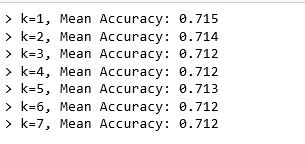

In [37]:
# performance with SMOTE and undersampling
from IPython.display import Image
Image(filename='Images\SMOTE+undersampling performance.JPG')

- Action:
    - trained a simple model to descern what is the optimal number of **k neighbours**.
    - there **isn't much difference**, 1 seems to be best

#without SMOTE

model = DecisionTreeClassifier()

#cross validation

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: %.3f' % mean(scores))

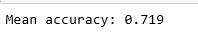

In [38]:
# performance without SMOTE 
Image(filename='Images\without SMOTE performance.JPG')

#apply SMOTE only

model = DecisionTreeClassifier()
oversample = SMOTE()
X_Smote, y_Smote = oversample.fit_resample(X, y)

#cross validation

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_Smote, y_Smote, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: %.3f' % mean(scores))

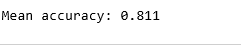

In [39]:
# performance with SMOTE 
Image(filename='Images\with SMOTE performance.PNG')

In [40]:
# apply Borderline SMOTE only
model = DecisionTreeClassifier()
oversample = BorderlineSMOTE()
X_BSmote, y_BSmote = oversample.fit_resample(X, y)

# cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X_BSmote, y_BSmote, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean accuracy: %.3f' % mean(scores))

Mean accuracy: 0.818


- Observation:
    - looks like applying undersampling together with SMOTE actually **worsens** model performance
    - applying **SMOTE is indeed much better than without**
    - applying **BorderlineSMOTE performed bette**r than regular SMOTE

# Training the models
- i will use only Borderline SMOTE for the remaining models

In [81]:
# stratified k fold to preserve the class proportions in every fold
kfold=StratifiedKFold(n_splits=10)

In [88]:
# training random forest model
random_state=2
classifier=RandomForestClassifier(random_state=random_state,n_jobs=-1,n_estimators=500)
cv_results=cross_val_score(classifier,X_BSmote, y_BSmote,cv=kfold,n_jobs=-1)

In [87]:
print("Cross Validation Score:",mean(cv_results))

Cross Validation Score: 0.8830628314152346


- Action: 
    - for this dataset, training the model takes too long, so i will **skip hyperparameter** tuning which will take even longer

# Learning Curves

In [89]:
def plot_learning_curve(estimator,title,X,y,ylim=None,cv=None,n_jobs=-1,train_sizes=np.linspace(0.1,1,5)):
    
    plt.figure(figsize=(12, 8))
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    
    train_sizes,train_scores,test_scores=learning_curve(estimator ,X , y,
                                                      cv=cv, 
                                                      n_jobs=n_jobs,
                                                      train_sizes=train_sizes)
    
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes,
                     train_scores_mean-train_scores_std,
                     train_scores_mean+train_scores_std, alpha= 0.1 ,color='y')
    plt.fill_between(train_sizes,
                     test_scores_mean-test_scores_std,
                     test_scores_mean+test_scores_std, alpha= 0.1 ,color='b')
    
    plt.plot(train_sizes,train_scores_mean,'o-',color='y',
            label='Training scores')
    plt.plot(train_sizes,test_scores_mean,'o-',color='b',
            label='Cross validation scores')
    
    plt.legend(loc='best')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\tanch\\AppData\\Roaming\\Python\\Python37\\site-packages\\matplotlib\\pyplot.py'>

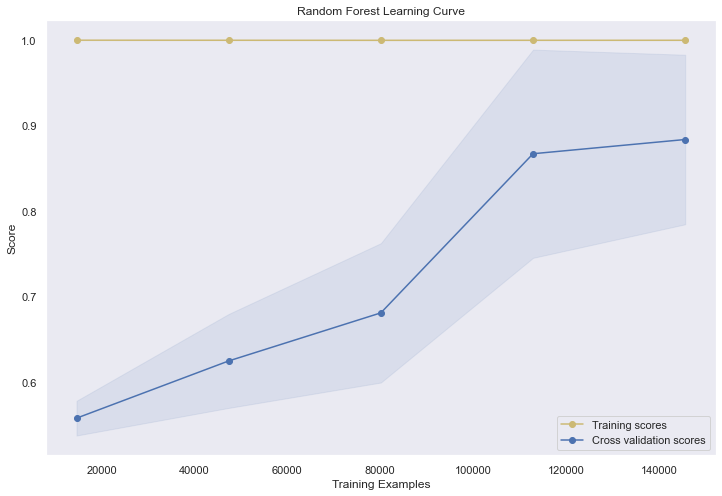

In [90]:
plot_learning_curve(classifier,'Random Forest Learning Curve',
                    X_BSmote, y_BSmote,
                    cv=kfold)

- Obersvation:
    - a significant differnce in training and cross validation scores suggest significant over fitting

### training on the whole training set

In [91]:
# random forest model
random_state=2
ranForClassifier=RandomForestClassifier(random_state=random_state,n_jobs=-1,n_estimators=500)
ranForClassifier.fit(X_BSmote, y_BSmote)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [116]:
# making probability predictions on the test set
test_predictions=ranForClassifier.predict_proba(test_set)
test_predictions

array([[0.994, 0.006],
       [0.928, 0.072],
       [0.966, 0.034],
       ...,
       [0.688, 0.312],
       [0.834, 0.166],
       [0.882, 0.118]])

- Observation:
    the **probablity of being delayed 15 min is on index 1**

In [117]:
# extract the probablity of being delayed 15 min
dep_delayed_15min=[]
for predictions in test_predictions:
    dep_delayed_15min.append(predictions[1])
dep_delayed_15min=pd.Series(dep_delayed_15min,name='dep_delayed_15min')

In [121]:
# extract the id column
test_set_id_column=pd.Series(range(len(test_set)),name='id')

In [122]:
# finalising results
results=pd.concat([test_set_id_column,dep_delayed_15min],axis=1)
results
    

,id,dep_delayed_15min
0,0,0.006
1,1,0.072
2,2,0.034
3,3,0.266
4,4,0.512
...,...,...
99995,99995,0.040
99996,99996,0.146
99997,99997,0.312
99998,99998,0.166


In [123]:
results.to_csv('randomForestPredictions.csv',index=False)

# First try results

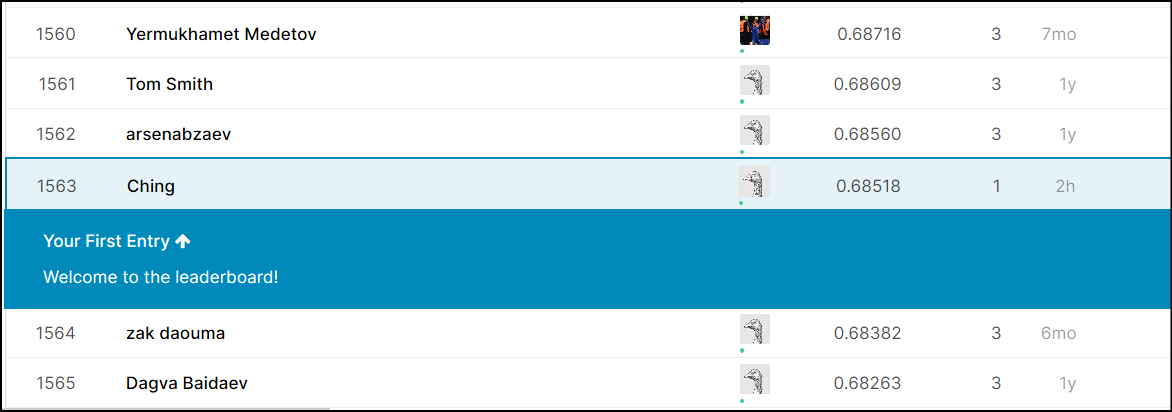

In [15]:
Image(filename='Images/first_try_results.png')

- performance on the training set was not very good on the first try

### Feature importances

In [98]:
X_BSmote=pd.DataFrame(X_BSmote,columns=column_sequence)

Text(0.5, 1.0, 'Feature Importance')

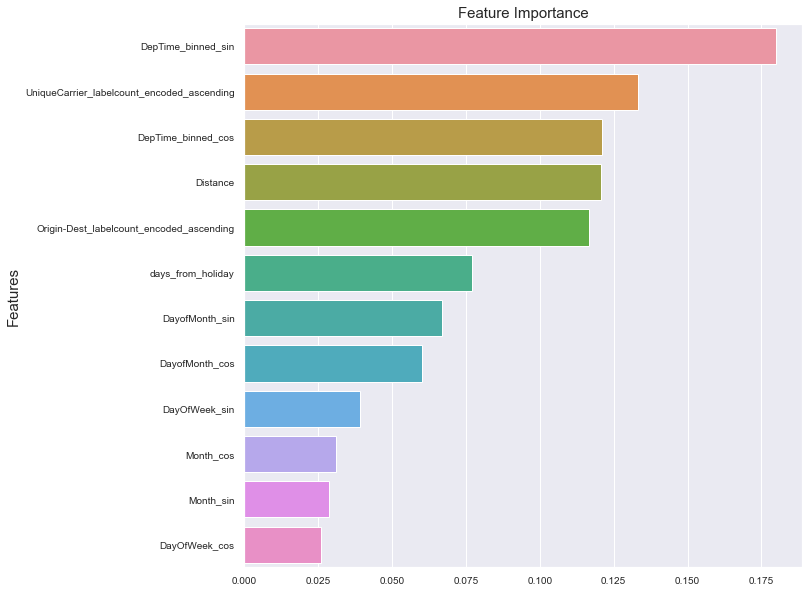

In [99]:
f, axes = plt.subplots(1,1 , figsize=(10, 10))
indices=np.argsort(ranForClassifier.feature_importances_)[::-1]
g=sb.barplot(y=X_BSmote.columns[indices],x=ranForClassifier.feature_importances_[indices])
g.set_ylabel('Features',fontsize=15)
g.tick_params(labelsize=10)
g.set_title('Feature Importance',fontsize=15)

- Observation:
    - as expected, **departure time is the strongest predictor**
    - carriers and distance a also quite important